In [1]:
from dataloader import load_balanced_dataset
import backend.src.utils.utils as utils

In [2]:
data = load_balanced_dataset()
data = utils.clean_text(data, "text")

In [3]:
data.head()

,sent_id,text,label
8467,501595-09-02,Versjonen får servert laget hyse frisk sma...,2
581,200183-02-01,Lexus store premium aktørene globalt fremmarsj...,2
9851,705105-08-05,Komponisten Asheim eget blikk komposisjonsmåte...,2
8140,704794-05-01,Dette spillet sikkert kjøp barn gamle Donkey K...,2
6883,305175-25-02,Dette faktisk veldig godt sa Robinson,2


<AxesSubplot:>

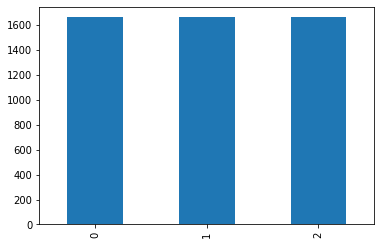

In [4]:
data["label"].value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

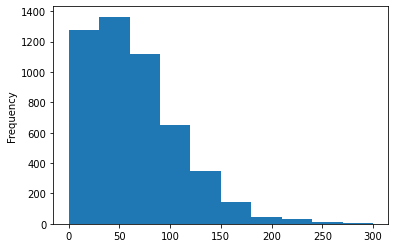

In [5]:
data["text"].str.len().plot.hist()

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(data["text"].values)

X = tokenizer.texts_to_sequences(data["text"].values)
X = pad_sequences(X)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

model = Sequential()
model.add(Embedding(20000, 128, input_length=X.shape[1]))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation="softmax"))

In [8]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 49, 128)           2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 2,691,971
Trainable params: 2,691,971
Non-trainable params: 0
_________________________________________________________________


In [9]:
import pandas as pd

y = pd.get_dummies(data["label"]).values

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
 25/175 [===>..........................] - ETA: 14s - loss: 1.0898 - accuracy: 0.3600

In [ ]:
from datetime import datetime

model.save(f"models/SA-LSTM-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss in the same figure but in two different plots
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)